# Manual

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.io import imread

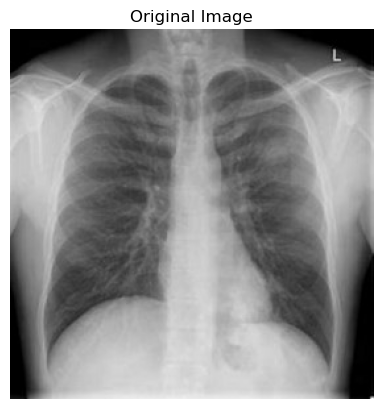

In [2]:
image = imread('lunar_orbiter.jpg')
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [3]:
gray_image = rgb2gray(image)
f_image = np.fft.fft2(gray_image)
fshift = np.fft.fftshift(f_image)
magnitude_spectrum = 20 * np.log(np.abs(fshift))

In [ ]:
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')
plt.axis('off')
plt.show()

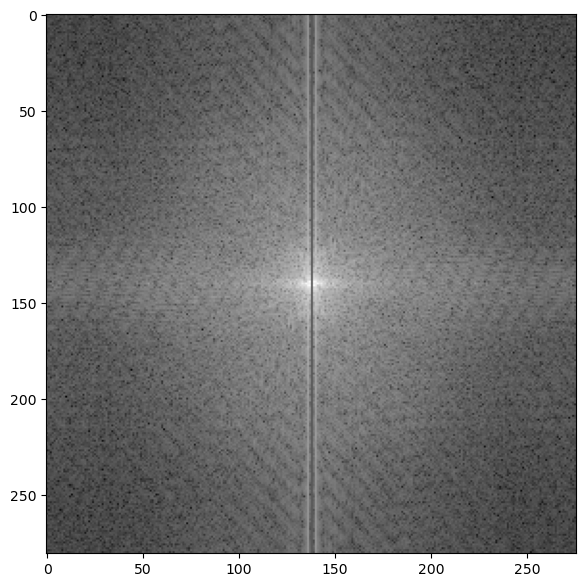

In [5]:
image_gray_fft2 = fshift.copy()
image_gray_fft2[:286, fshift.shape[1]//2] = 1
image_gray_fft2[-286:, fshift.shape[1]//2] = 1

plt.figure(figsize=(7,7))
plt.imshow(np.log(abs(image_gray_fft2)), cmap='gray')

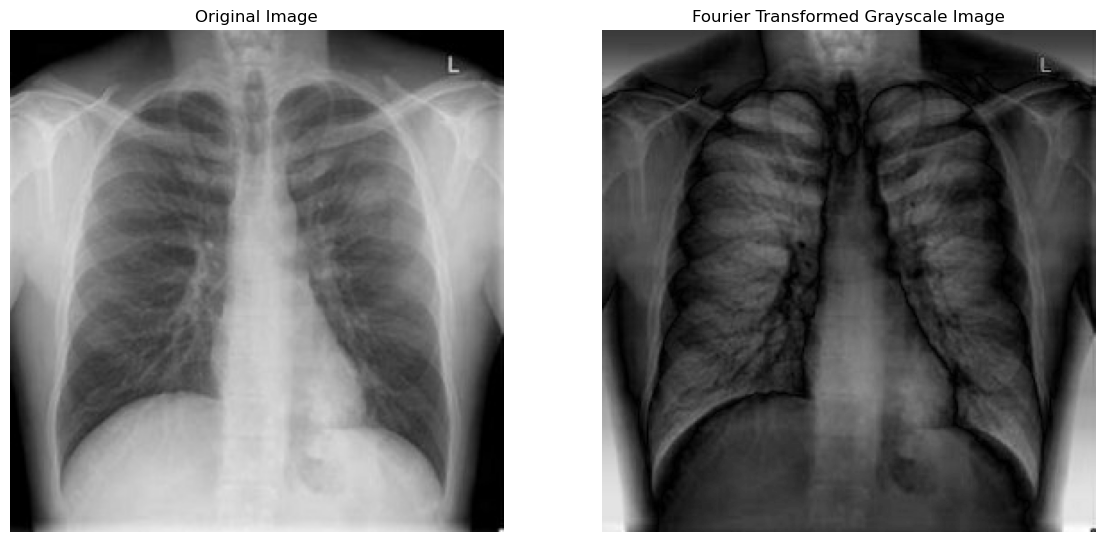

In [6]:
# Use Inverse Fourier Transform
inv_fshift = np.fft.ifftshift(image_gray_fft2)
filtered_gray_image = np.fft.ifft2(inv_fshift)
filtered_gray_image = np.abs(filtered_gray_image)

# Plot the original and fourier-transformed grayscale image
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(filtered_gray_image, cmap='gray')
ax[1].set_title('Fourier Transformed Grayscale Image')
ax[1].axis('off')

plt.show()


In [7]:
transformed_channels = []
for i in range(3):
    rgb_fft = np.fft.fftshift(np.fft.fft2((image[:, :, i])))
    rgb_fft2 = rgb_fft.copy()
    
    # Use the same filters as the grayscale image, just change the variables
    rgb_fft2[:286, rgb_fft.shape[1]//2] = 1
    rgb_fft2[-286:, rgb_fft.shape[1]//2] = 1
    transformed_channels.append(abs(np.fft.ifft2(np.fft.ifftshift(rgb_fft2))))
filtered_rgb_image = np.dstack([transformed_channels[0], transformed_channels[1], transformed_channels[2]])

In [8]:

filtered_rgb_image = np.clip(filtered_rgb_image, 0, 255).astype(np.uint8)


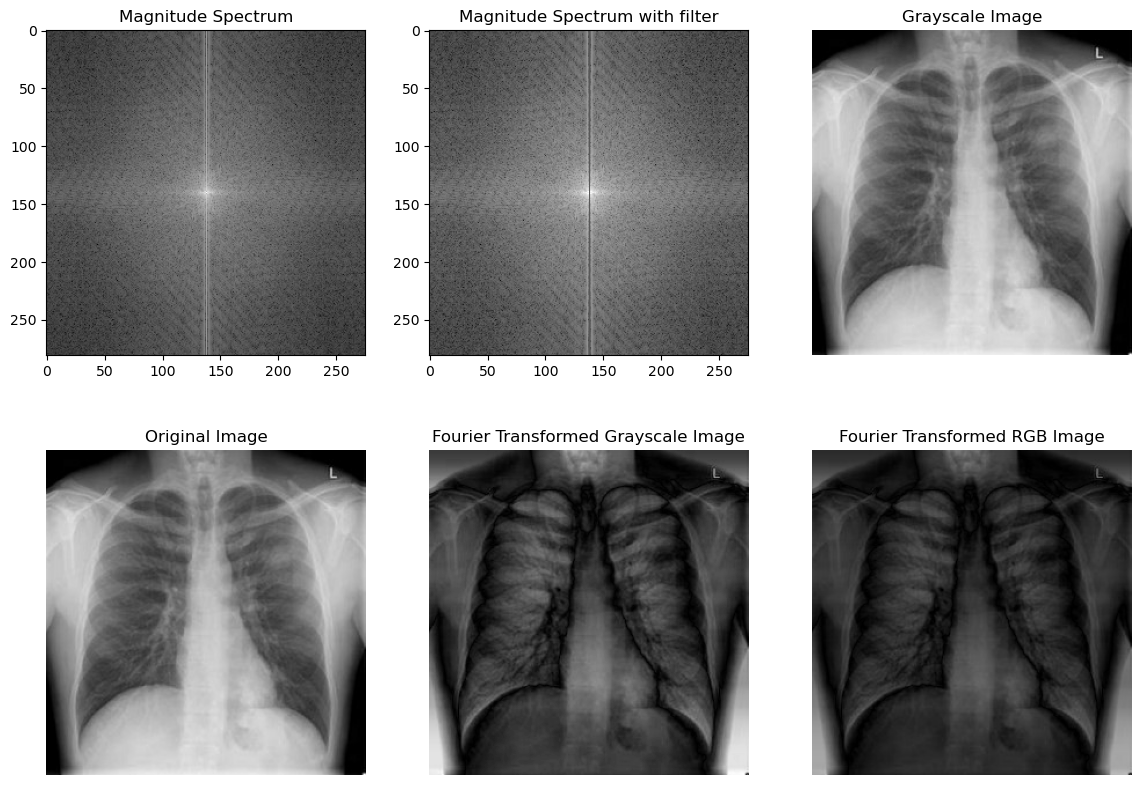

In [9]:
def plot_fourier_transformer(image, filtered_gray_image, filtered_rgb_image):
    
    if len(image.shape) == 2:
        image = np.stack((image, image, image), axis=-1)

    # Convert the image to grayscale
    gray_image = rgb2gray(image[:,:,:3])
    
    # Calculate the 2D Fourier transform and shift the zero-frequency components to the center
    f_image = np.fft.fft2(gray_image)
    fshift = np.fft.fftshift(f_image)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))

    # Plot the images
    fig, ax = plt.subplots(2, 3, figsize=(14, 10))

    ax[0, 0].imshow(magnitude_spectrum, cmap='gray')
    ax[0, 0].set_title('Magnitude Spectrum')

    ax[0, 1].imshow(magnitude_spectrum, cmap='gray')
    ax[0, 1].imshow(np.log(abs(image_gray_fft2)), cmap='gray')
    ax[0, 1].set_title('Magnitude Spectrum with filter')

    ax[0, 2].imshow(gray_image, cmap='gray')
    ax[0, 2].set_title('Grayscale Image')
    ax[0, 2].set_axis_off()

    ax[1, 0].imshow(image)
    ax[1, 0].set_title('Original Image')
    ax[1, 0].set_axis_off()

    ax[1, 1].imshow(filtered_gray_image, cmap='gray')
    ax[1, 1].set_title('Fourier Transformed Grayscale Image')
    ax[1, 1].set_axis_off()

    ax[1, 2].imshow(filtered_rgb_image)
    ax[1, 2].set_title('Fourier Transformed RGB Image')
    ax[1, 2].set_axis_off()

    # Save the Fourier-transformed RGB image
    plt.savefig('filtered_rgb_image.png', dpi=300)
    plt.show()

plot_fourier_transformer(image, filtered_gray_image, filtered_rgb_image)

# Equalisation

In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import data,exposure
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage.morphology import disk,ball
from skimage.filters import rank

matplotlib.rcParams['font.size'] = 9

In [13]:
def plot_img_and_hist(image,axes,bins=256):
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()
    
    ax_img.imshow(image,cmap=plt.cm.gray)
    ax_img.set_axis_off()
    
    ax_hist.hist(image.ravel(),bins=bins)
    ax_hist.ticklabel_format(axis='y',style='scientific',scilimits=(0,0))
    ax_hist.set_xlabel('Pixel intensity')
    
    xmin,xmax = dtype_range[image.dtype.type]
    ax_hist.set_xlim(xmin,xmax)
    
    img_cdf, bins = exposure.cumulative_distribution(image,bins)
    ax_cdf.plot(bins,img_cdf,color='r')
    
    return ax_img, ax_hist, ax_cdf

In [14]:
img = img_as_ubyte(data.moon())

img_rescale = exposure.equalize_hist(img)

footprint = disk(30)

img_eq = rank.equalize(img,footprint=footprint)

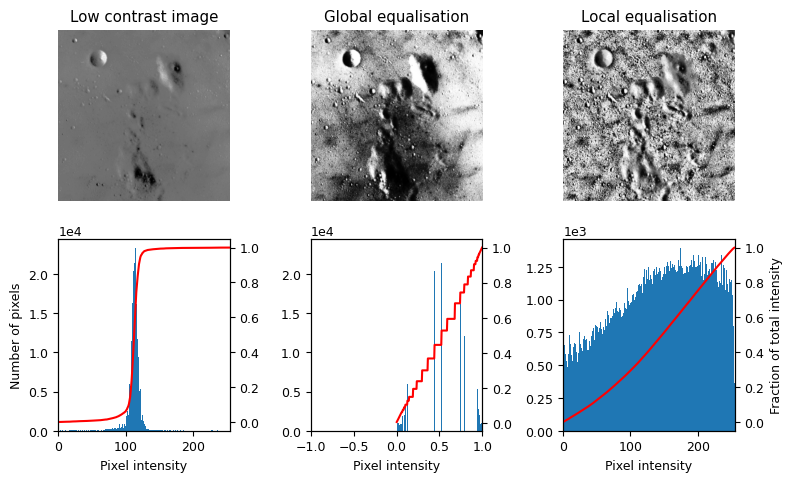

In [16]:
fig = plt.figure(figsize=(8,5))
axes = np.zeros((2,3),dtype=object)
axes[0,0] = fig.add_subplot(2,3,1)
axes[0,1] = fig.add_subplot(2,3,2,sharex=axes[0,0],sharey=axes[0,0])
axes[0,2] = fig.add_subplot(2,3,3,sharex=axes[0,0],sharey=axes[0,0])
axes[1,0] = fig.add_subplot(2,3,4)
axes[1,1] = fig.add_subplot(2,3,5)
axes[1,2] = fig.add_subplot(2,3,6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img,axes[:,0])
ax_img.set_title('Low contrast image')
ax_hist.set_ylabel('Number of pixels')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale,axes[:,1])
ax_img.set_title('Global equalisation')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq,axes[:,2])
ax_img.set_title('Local equalisation')
ax_cdf.set_ylabel('Fraction of total intensity')

fig.tight_layout()

# Assignment

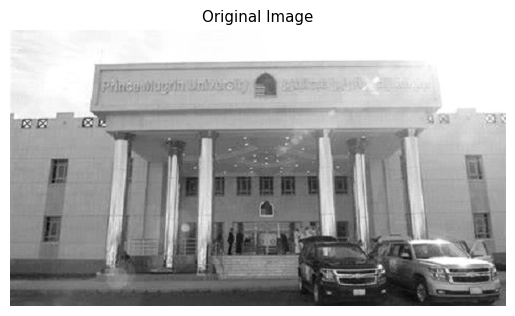

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.exposure import equalize_hist, adjust_gamma

assignment_image = io.imread('Submission/upm.jpg', as_gray=True)
plt.imshow(assignment_image, cmap= 'gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

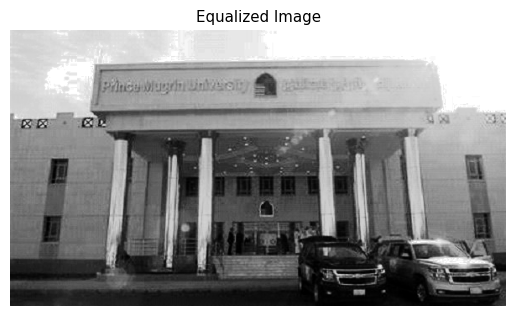

In [120]:
equalized_img = equalize_hist(assignment_image)

plt.imshow(equalized_img, cmap= 'gray')
plt.title('Equalized Image')
plt.axis('off')
plt.show()


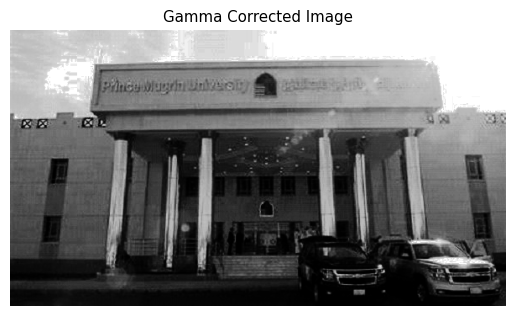

In [125]:
gamma_corrected_img = adjust_gamma(equalized_img, gamma=1.5)
plt.imshow(gamma_corrected_img, cmap= 'gray')
plt.title('Gamma Corrected Image')
plt.axis('off')
plt.show()

In [129]:
plt.imsave("enhanced_img.jpg", gamma_corrected_img, cmap='gray')

C:\Users\4311779\AppData\Local\Temp\ipykernel_19648\880124529.py:16: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20 * np.log(np.abs(fshift_filtered))


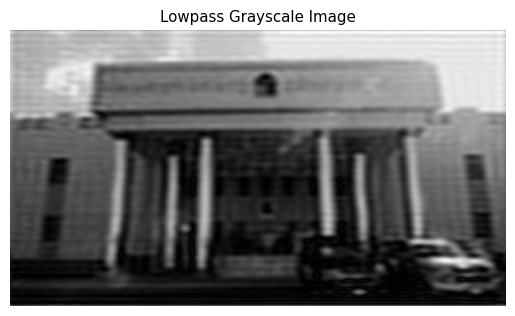

ValueError: Images of type float must be between -1 and 1.

In [127]:
gray_image = gamma_corrected_img
f_image = np.fft.fft2(gray_image)
fshift = np.fft.fftshift(f_image)

rows, cols = gray_image.shape
crow, ccol = rows // 2 , cols // 2  # center

radius = 40  # Adjust the radius for the low-pass filter
disk_mask = disk(radius)

lowpass_mask = np.zeros((rows, cols))
lowpass_mask[crow - radius:crow + radius + 1, ccol - radius:ccol + radius + 1] = disk_mask

fshift_filtered = fshift * lowpass_mask

magnitude_spectrum = 20 * np.log(np.abs(fshift_filtered))

# Apply the inverse shift and inverse Fourier Transform to get the filtered image
inv_fshift = np.fft.ifftshift(fshift_filtered)
lowpass_gray_upm = np.fft.ifft2(inv_fshift)
lowpass_gray_upm = np.abs(lowpass_gray_upm)

plt.imshow(lowpass_gray_upm, cmap='gray')
plt.title('Lowpass Grayscale Image')
plt.axis('off')
plt.show()

In [128]:
plt.imsave("lowpass_gray_upm.jpg", lowpass_gray_upm, cmap='gray')

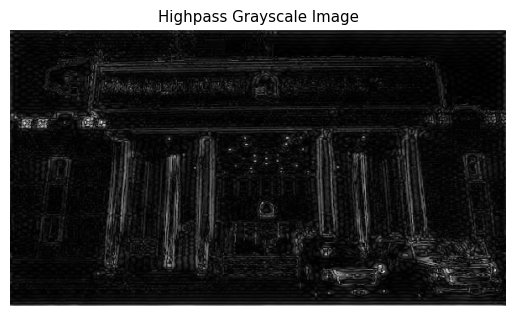

In [130]:
highpass_mask = 1 - lowpass_mask
fshift_filtered = fshift * highpass_mask
inv_fshift = np.fft.ifftshift(fshift_filtered)
highpass_gray_upm = np.fft.ifft2(inv_fshift)
highpass_gray_upm = np.abs(highpass_gray_upm)

plt.imshow(highpass_gray_upm, cmap='gray')
plt.title('Highpass Grayscale Image')
plt.axis('off')
plt.show()


In [131]:
plt.imsave("highpass_gray_upm.jpg", highpass_gray_upm, cmap='gray')